# COGS 108 - EDA Checkpoint

# Names

- Aditya Sriram
- Nicole Liu
- Weston Chester
- Sophia Conti
- Katherine Gao

<a id='research_question'></a>
# Research Question

Is California on track to reach its goal of 100% zero emission sales by 2035?

# Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import seaborn as sns

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

population = pd.read_csv('Data/Cali_county_population.csv')

zev_sales = pd.read_csv('Data/zev_sales.csv')

reg_2008 = pd.read_csv('Data/Vehicles Registered By County-2008.csv', encoding='utf-16')
reg_2009 = pd.read_csv('Data/Vehicles Registered By County-2009.csv', encoding='utf-16')
reg_2010 = pd.read_csv('Data/Vehicles Registered By County-2010.csv', encoding='utf-16')
reg_2011 = pd.read_csv('Data/Vehicles Registered By County-2011.csv', encoding='utf-16')
reg_2012 = pd.read_csv('Data/Vehicles Registered By County-2012.csv', encoding='utf-16')
reg_2013 = pd.read_csv('Data/Vehicles Registered By County-2013.csv', encoding='utf-16')
reg_2014 = pd.read_csv('Data/Vehicles Registered By County-2014.csv', encoding='utf-16')
reg_2015 = pd.read_csv('Data/Vehicles Registered By County-2015.csv', encoding='utf-16')
reg_2016 = pd.read_csv('Data/Vehicles Registered By County-2016.csv', encoding='utf-16')
reg_2017 = pd.read_csv('Data/Vehicles Registered By County-2017.csv', encoding='utf-16')
reg_2018 = pd.read_csv('Data/Vehicles Registered By County-2018.csv', encoding='utf-16')
reg_2019 = pd.read_csv('Data/Vehicles Registered By County-2019.csv', encoding='utf-16')
reg_2020 = pd.read_csv('Data/Vehicles Registered By County-2020.csv', encoding='utf-16')
reg_2021 = pd.read_csv('Data/Vehicles Registered By County-2021.csv', encoding='utf-16')

ev_sales = pd.read_csv("Data/Electric_Car_Sales_by_Model_in_USA.csv")

legislation = pd.read_csv('Data/legislation.csv')

# Data Cleaning

We start with the dataframe for ZEV sales.

In [2]:
zev_sales.isna().groupby('Data Year').sum()

,County,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
Data Year,,,,,
False,0,0,0,0,0


Looks like theres no NaN data in this set. We should check for placeholder values ('-' or '-99'), though.

In [3]:
#zev_sales[zev_sales.eq('-').any(1)].shape[0] + zev_sales[zev_sales.eq('-99').any(1)].shape[0]

Looks like theres no '-' or '-99' either! Good job DMV.

In either case, we are looking to merge this dataset with a secondary one about car registrations, which only has data up to the year 2021. We should filter this dataset (which is about number of cars sold) to the time period of cars sold in 2021 and before. 

In [4]:
zev_sales = zev_sales.rename(columns={'Data Year':'Year'})
zev_sales = zev_sales[zev_sales['Year'] <= 2021]

zev_sales

,Year,County,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
0,1998,Los Angeles,Electric,Ford,Ranger,1
1,1998,Orange,Electric,Ford,Ranger,1
2,1998,San Bernardino,Electric,Ford,Ranger,2
3,1998,San Mateo,Electric,Ford,Ranger,1
4,1999,Santa Barbara,Electric,Ford,Ranger,1
...,...,...,...,...,...,...
12465,2021,Yuba,PHEV,Kia,Sorento PHEV,1
12466,2021,Yuba,PHEV,Subaru,Crosstrek,3
12467,2021,Yuba,PHEV,Toyota,Prius Prime,16
12468,2021,Yuba,PHEV,Toyota,RAV4 Prime,4


We also see that the age of the average car in 2021 is [12 years](https://www.caranddriver.com/news/a33457915/average-age-vehicles-on-road-12-years/). However, EV batteries are predicted to last between [12-15 years](https://cars.usnews.com/cars-trucks/advice/how-long-do-ev-batteries-last), meaning that they would potentially last longer than the body of the car itself. Thus, we will say that we expect the average lifetime of an electric vehicle to be 12 years. Our dataset has its oldest car dating to 1998. By the average 12 year lifespan, we no longer expect that car to be in use and so it should be removed from the dataset. <br>

If we look at total automobile registrations in 2021, which is the most recent year from the other dataset, we would expect the oldest car registered (on average) to be 12 years old. This leads us to the conclusion that we should only look at ZEVs sold in or after 2009 in order to remain in the proper time frame.

In [5]:
zev_sales = zev_sales[zev_sales['Year'] >= 2009]

zev_sales['Year'] = zev_sales['Year'].astype(int) #- 2009
zev_sales['Number of Vehicles'] = zev_sales['Number of Vehicles'].astype(int)

zev_sales

C:\Users\17144\AppData\Local\Temp\ipykernel_32720\1569772103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zev_sales['Year'] = zev_sales['Year'].astype(int) #- 2009
C:\Users\17144\AppData\Local\Temp\ipykernel_32720\1569772103.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zev_sales['Number of Vehicles'] = zev_sales['Number of Vehicles'].astype(int)


,Year,County,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
19,2009,Alameda,Electric,Tesla,Roadster,5
20,2009,Contra Costa,Electric,Tesla,Roadster,1
21,2009,Humboldt,Electric,Ford,Ranger,1
22,2009,Kern,Electric,Tesla,Roadster,1
23,2009,Los Angeles,Electric,MINI,Cooper,6
...,...,...,...,...,...,...
12465,2021,Yuba,PHEV,Kia,Sorento PHEV,1
12466,2021,Yuba,PHEV,Subaru,Crosstrek,3
12467,2021,Yuba,PHEV,Toyota,Prius Prime,16
12468,2021,Yuba,PHEV,Toyota,RAV4 Prime,4


In [6]:


by_year = zev_sales.groupby('Year').sum()
by_year = by_year.drop(columns=['County', 'FUEL_TYPE', 'MAKE','MODEL'])


count_per_year = by_year['Number of Vehicles'].values

cumulative = []

for i in range(len(count_per_year)):
    cumulative.append(sum(count_per_year[0:i + 1]))
    
    
by_year['Cumulative Sales'] = cumulative

print('The total number of ZEVs sold between 2009 and 2021 is ' + str(sum(count_per_year)))

by_year

The total number of ZEVs sold between 2009 and 2021 is 1054067


,Number of Vehicles,Cumulative Sales
Year,,
2009,84,84
2010,661,745
2011,6743,7488
2012,17839,25327
2013,39805,65132
2014,58663,123795
2015,64134,187929
2016,72683,260612
2017,93587,354199


Now onto the total registrations dataset. Some intial cleaning was done to the data by hand as the csv data was delimited by tabs instead of commas, so the delimiter were replaced inorder to be read in. 

In [7]:
all_sets = [reg_2008,reg_2009,reg_2010,reg_2011,reg_2012,reg_2013,reg_2014,reg_2015,reg_2016,reg_2017,reg_2018,reg_2019,reg_2020,reg_2021]
year = 2008
for df in all_sets:
    df['Year'] = year
    year += 1;
    
registrations = pd.concat(all_sets).reset_index(drop= True)
registrations
    

,Counties,Autos,Trucks,Trailers,Motorcycles,Total Vehicles,Year
0,ALAMEDA,932092.0,194392.0,71257.0,31389.0,1229130,2008
1,ALPINE,1030.0,526.0,360.0,62.0,1978,2008
2,AMADOR,26926.0,15114.0,10163.0,2113.0,54316,2008
3,BUTTE,121017.0,54233.0,43693.0,6965.0,225908,2008
4,CALAVERAS,34297.0,19762.0,14928.0,2771.0,71758,2008
...,...,...,...,...,...,...,...
877,OUT OF STATE,109678.0,46415.0,66372.0,4975.0,227440,2021
878,IRP VEHICLES*,NaN,NaN,NaN,NaN,2099129,2021
879,MISC VEHICLES,NaN,NaN,NaN,NaN,121716,2021
880,FEE EXEMPT VEHICLES,231370.0,309182.0,75483.0,13223.0,629258,2021


We have first merged the separate tables into one and then added their year as a variable. We can now move on to removing non-relevant data.

In [8]:
registrations = registrations.dropna()
registrations = registrations[registrations.Counties != 'FEE EXEMPT VEHICLES'][registrations.Counties != 'IRP VEHICLES*'][registrations.Counties != 'MISC VEHICLES'][registrations.Counties != 'STATEWIDE']
registrations

C:\Users\17144\AppData\Local\Temp\ipykernel_32720\1924242407.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  registrations = registrations[registrations.Counties != 'FEE EXEMPT VEHICLES'][registrations.Counties != 'IRP VEHICLES*'][registrations.Counties != 'MISC VEHICLES'][registrations.Counties != 'STATEWIDE']
C:\Users\17144\AppData\Local\Temp\ipykernel_32720\1924242407.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  registrations = registrations[registrations.Counties != 'FEE EXEMPT VEHICLES'][registrations.Counties != 'IRP VEHICLES*'][registrations.Counties != 'MISC VEHICLES'][registrations.Counties != 'STATEWIDE']
C:\Users\17144\AppData\Local\Temp\ipykernel_32720\1924242407.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  registrations = registrations[registrations.Counties != 'FEE EXEMPT VEHICLES'][registrations.Counties != 'IRP VEHICLES*'][registrations.Counties != 'MISC VEH

,Counties,Autos,Trucks,Trailers,Motorcycles,Total Vehicles,Year
0,ALAMEDA,932092.0,194392.0,71257.0,31389.0,1229130,2008
1,ALPINE,1030.0,526.0,360.0,62.0,1978,2008
2,AMADOR,26926.0,15114.0,10163.0,2113.0,54316,2008
3,BUTTE,121017.0,54233.0,43693.0,6965.0,225908,2008
4,CALAVERAS,34297.0,19762.0,14928.0,2771.0,71758,2008
...,...,...,...,...,...,...,...
873,TUOLUMNE,40557.0,22158.0,15416.0,3076.0,81207,2021
874,VENTURA,596553.0,149531.0,54714.0,24345.0,825143,2021
875,YOLO,124118.0,38217.0,26301.0,4308.0,192944,2021
876,YUBA,44088.0,17588.0,13875.0,2485.0,78036,2021


We here drop any rows with null values. We also removed rows that include data on nonconsumer vehicles, which includes the statewide data.

In [9]:
registrations = registrations.drop(columns=['Trailers', 'Motorcycles'])
registrations['Total Vehicles'] = registrations['Autos'] + registrations['Trucks']
registrations

,Counties,Autos,Trucks,Total Vehicles,Year
0,ALAMEDA,932092.0,194392.0,1126484.0,2008
1,ALPINE,1030.0,526.0,1556.0,2008
2,AMADOR,26926.0,15114.0,42040.0,2008
3,BUTTE,121017.0,54233.0,175250.0,2008
4,CALAVERAS,34297.0,19762.0,54059.0,2008
...,...,...,...,...,...
873,TUOLUMNE,40557.0,22158.0,62715.0,2021
874,VENTURA,596553.0,149531.0,746084.0,2021
875,YOLO,124118.0,38217.0,162335.0,2021
876,YUBA,44088.0,17588.0,61676.0,2021


We have now removed any vehicles that we are not focusing on, such as motorcycles and trailers, and have updated the total vehicles column accordingly.

In [10]:
registrations['Delta'] = 0 
registrations = registrations.sort_values(['Counties','Year']).reset_index(drop= True)
registrations['Delta'].loc[registrations['Year'] != 2008] = registrations['Total Vehicles'].diff()
registrations = registrations[registrations["Year"] >= 2009]
registrations


C:\Users\17144\AppData\Local\Temp\ipykernel_32720\633219372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  registrations['Delta'].loc[registrations['Year'] != 2008] = registrations['Total Vehicles'].diff()


,Counties,Autos,Trucks,Total Vehicles,Year,Delta
1,ALAMEDA,937076.0,188715.0,1125791.0,2009,-693
2,ALAMEDA,952005.0,184257.0,1136262.0,2010,10471
3,ALAMEDA,954158.0,177376.0,1131534.0,2011,-4728
4,ALAMEDA,974615.0,175467.0,1150082.0,2012,18548
5,ALAMEDA,1010519.0,176958.0,1187477.0,2013,37395
...,...,...,...,...,...,...
821,YUBA,40802.0,16102.0,56904.0,2017,777
822,YUBA,41347.0,16227.0,57574.0,2018,670
823,YUBA,42839.0,16745.0,59584.0,2019,2010
824,YUBA,42929.0,17029.0,59958.0,2020,374


In [11]:
regs_tot = registrations.groupby(["Year"]).sum().drop(columns=['Counties'])
regs_tot

,Autos,Trucks,Total Vehicles,Delta
Year,,,,
2009,21898286.0,5788504.0,27686790.0,-152695
2010,22040779.0,5711052.0,27751831.0,65041
2011,22083049.0,5561453.0,27644502.0,-107329
2012,22473717.0,5530290.0,28004007.0,359505
2013,23237523.0,5584074.0,28821597.0,817590
2014,23805920.0,5591533.0,29397453.0,575856
2015,24487807.0,5648187.0,30135994.0,738541
2016,25244537.0,5812320.0,31056857.0,920863
2017,25467663.0,5850286.0,31317949.0,261092


We can now add a column that tells us the difference in registered cars from year to year in order to observe overall trends in car ownership. With this the data is now ready to be compared with the other dataset. <br>

Now onto the final dataset. This dataset is sorted with EV make and model on the rows and months on the columns, with the number of units sold as the data entries. 

In [12]:
ev_sales

,Make,Model,Logo,janv-12,Feb 2012,mars-12,Apr 2012,May 2012,juin-12,juil-12,...,mars-19,Apr 2019,May 2019,juin-19,juil-19,Aug 2019,sept-19,oct-19,nov-19,Dec 2019
0,Chevrolet,Volt,https://www.carlogos.org/logo/Chevrolet-logo-2...,603.0,1626.0,3915.0,5377.0,7057.0,8817.0,10666.0,...,146667.0,147072.0,"147,48","147,813","148,063","148,337","148,687","148,757","148,907","149,057"
1,Toyota,Prius PHV,https://www.carlogos.org/logo/Toyota-logo-1989...,0.0,21.0,912.0,2566.0,3652.0,4347.0,5035.0,...,42345.0,42345.0,42345,42345,42345,42345,42345,42345,42345,42345
2,Nissan,Leaf,https://www.carlogos.org/logo/Nissan-logo-2013...,676.0,1154.0,1733.0,2103.0,2613.0,3148.0,3543.0,...,122534.0,123485.0,"124,701","125,857","126,795","127,912","128,96","129,847","130,987","132,214"
3,Tesla,Model S,https://www.carlogos.org/logo/Tesla-logo-2003-...,0.0,NaN,NaN,NaN,NaN,12.0,31.0,...,147517.0,148342.0,"149,367","151,117","152,092","153,142","154,242","154,992","156,492","157,992"
4,Ford,C-Max Energi,https://www.carlogos.org/logo/Ford-logo-2003-1...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,42231.0,42231.0,42231,42231,42231,42231,42231,42231,42231,42231
5,Ford,Focus Electric,https://www.carlogos.org/logo/Ford-logo-2003-1...,2.0,2.0,2.0,2.0,8.0,97.0,135.0,...,9242.0,9242.0,9242,9242,9242,9242,9242,9242,9242,9242
6,Mitsubishi,i-MiEV,https://www.carlogos.org/logo/Mitsubishi-logo-...,36.0,80.0,136.0,215.0,300.0,333.0,366.0,...,2028.0,2028.0,2028,2028,2028,2028,2028,2028,2028,2028
7,Toyota,Rav4 EV,https://www.carlogos.org/logo/Toyota-logo-1989...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2472.0,2472.0,2472,2472,2472,2472,2472,2472,2472,2472
8,Honda,Fit EV,https://www.carlogos.org/logo/Honda-logo-1920x...,0.0,NaN,NaN,NaN,NaN,NaN,7.0,...,1069.0,1069.0,1069,1069,1069,1069,1069,1069,1069,1069
9,Ford,Fusion Energi,https://www.carlogos.org/logo/Ford-logo-2003-1...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,62774.0,63359.0,"63,964","64,639","65,359","65,979","66,679","67,279‬","67,879","68,557"


We see there is a row called `logo` which contains a link to the logo of the car company. We don't need this so we will drop this row. Additionally, we will fill all `NaN` values with 0s.

In [13]:
ev_sales.drop("Logo", inplace = True, axis = 1)
ev_sales = ev_sales.fillna(0)

ev_sales

,Make,Model,janv-12,Feb 2012,mars-12,Apr 2012,May 2012,juin-12,juil-12,Aug 2012,...,mars-19,Apr 2019,May 2019,juin-19,juil-19,Aug 2019,sept-19,oct-19,nov-19,Dec 2019
0,Chevrolet,Volt,603.0,1626.0,3915.0,5377.0,7057.0,8817.0,10666.0,13497.0,...,146667.0,147072.0,"147,48","147,813","148,063","148,337","148,687","148,757","148,907","149,057"
1,Toyota,Prius PHV,0.0,21.0,912.0,2566.0,3652.0,4347.0,5035.0,6082.0,...,42345.0,42345.0,42345,42345,42345,42345,42345,42345,42345,42345
2,Nissan,Leaf,676.0,1154.0,1733.0,2103.0,2613.0,3148.0,3543.0,4228.0,...,122534.0,123485.0,"124,701","125,857","126,795","127,912","128,96","129,847","130,987","132,214"
3,Tesla,Model S,0.0,0.0,0.0,0.0,0.0,12.0,31.0,74.0,...,147517.0,148342.0,"149,367","151,117","152,092","153,142","154,242","154,992","156,492","157,992"
4,Ford,C-Max Energi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42231.0,42231.0,42231,42231,42231,42231,42231,42231,42231,42231
5,Ford,Focus Electric,2.0,2.0,2.0,2.0,8.0,97.0,135.0,169.0,...,9242.0,9242.0,9242,9242,9242,9242,9242,9242,9242,9242
6,Mitsubishi,i-MiEV,36.0,80.0,136.0,215.0,300.0,333.0,366.0,403.0,...,2028.0,2028.0,2028,2028,2028,2028,2028,2028,2028,2028
7,Toyota,Rav4 EV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2472.0,2472.0,2472,2472,2472,2472,2472,2472,2472,2472
8,Honda,Fit EV,0.0,0.0,0.0,0.0,0.0,0.0,7.0,16.0,...,1069.0,1069.0,1069,1069,1069,1069,1069,1069,1069,1069
9,Ford,Fusion Energi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62774.0,63359.0,"63,964","64,639","65,359","65,979","66,679","67,279‬","67,879","68,557"


We can now create a dataframe to compare the zev sales to the total number of registered cars.

In [14]:
regs_v_ev = pd.concat([regs_tot, by_year]).groupby(["Year"]).sum()
regs_v_ev["Total_NonEv"] = regs_v_ev['Total Vehicles'] - regs_v_ev['Cumulative Sales']
regs_v_ev = regs_v_ev.rename(columns={'Number of Vehicles':'EV_Sales', 'Total Vehicles':'Total_Vehicles'})
regs_v_ev = regs_v_ev.reset_index()

We will now do a little cleaning on the population data.

In [15]:
population = population.drop(columns=['Census', 'Estimates Base'])
population = population.rename(columns={'Geographic Area':'county'})
population

,county,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,California,"37,319,502","37,638,369","37,948,800","38,260,787","38,596,972","38,918,045","39,167,117","39,358,497","39,461,588","39,512,223"
1,".Alameda County, California","1,512,986","1,530,915","1,553,764","1,579,593","1,607,792","1,634,538","1,650,950","1,660,196","1,666,756","1,671,329"
2,".Alpine County, California","1,161","1,093","1,110","1,128","1,080","1,077","1,047","1,111","1,089","1,129"
3,".Amador County, California","37,886","37,543","37,104","36,620","36,726","37,031","37,429","38,529","39,405","39,752"
4,".Butte County, California","219,949","219,975","220,869","221,641","223,516","224,631","226,231","228,696","230,339","219,186"
5,".Calaveras County, California","45,468","45,160","44,815","44,655","44,671","44,965","45,322","45,681","45,698","45,905"
6,".Colusa County, California","21,437","21,323","21,284","21,250","21,176","21,231","21,496","21,579","21,418","21,547"
7,".Contra Costa County, California","1,052,540","1,065,440","1,077,548","1,093,401","1,108,876","1,124,405","1,137,268","1,145,535","1,150,519","1,153,526"
8,".Del Norte County, California","28,566","28,443","28,190","27,816","27,175","27,190","27,382","27,351","27,740","27,812"
9,".El Dorado County, California","181,136","180,936","180,575","181,481","183,108","184,569","185,976","188,679","190,746","192,843"


In [16]:
def fix_county(str_in):

    str_in = str_in.replace('.', '')
    str_in = str_in.replace('County, California', '')
    str_in = str_in.strip()
    str_in = str_in.upper()
    
    return str_in

In [17]:
population['county'] = population['county'].apply(fix_county)
population

,county,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,CALIFORNIA,"37,319,502","37,638,369","37,948,800","38,260,787","38,596,972","38,918,045","39,167,117","39,358,497","39,461,588","39,512,223"
1,ALAMEDA,"1,512,986","1,530,915","1,553,764","1,579,593","1,607,792","1,634,538","1,650,950","1,660,196","1,666,756","1,671,329"
2,ALPINE,"1,161","1,093","1,110","1,128","1,080","1,077","1,047","1,111","1,089","1,129"
3,AMADOR,"37,886","37,543","37,104","36,620","36,726","37,031","37,429","38,529","39,405","39,752"
4,BUTTE,"219,949","219,975","220,869","221,641","223,516","224,631","226,231","228,696","230,339","219,186"
5,CALAVERAS,"45,468","45,160","44,815","44,655","44,671","44,965","45,322","45,681","45,698","45,905"
6,COLUSA,"21,437","21,323","21,284","21,250","21,176","21,231","21,496","21,579","21,418","21,547"
7,CONTRA COSTA,"1,052,540","1,065,440","1,077,548","1,093,401","1,108,876","1,124,405","1,137,268","1,145,535","1,150,519","1,153,526"
8,DEL NORTE,"28,566","28,443","28,190","27,816","27,175","27,190","27,382","27,351","27,740","27,812"
9,EL DORADO,"181,136","180,936","180,575","181,481","183,108","184,569","185,976","188,679","190,746","192,843"


# Data Analysis & Results (EDA)

We can first take a look at car ownership/registration over time and how it compares to the total amount of Zev sales since 2009.

Text(0.5, 1.0, 'Total Trend in Registrations')

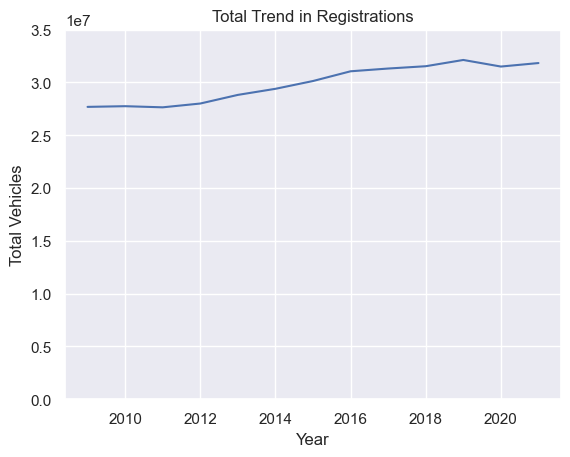

In [18]:
sns.set(font_scale=1)

plt.ylim([0, 35000000])
sns.lineplot(data = regs_tot, x = 'Year', y='Total Vehicles', errorbar = None).set_title("Total Trend in Registrations")


Text(0.5, 1.0, 'Trend in Registrations for Non-Electric Vehicles')

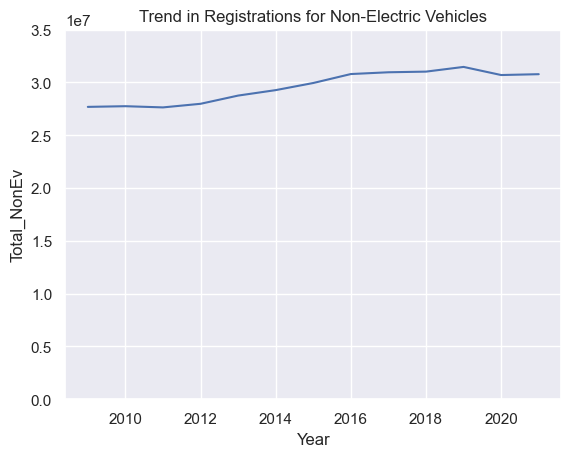

In [19]:
plt.ylim([0, 35000000])
sns.lineplot(data = regs_v_ev, x = 'Year', y="Total_NonEv", errorbar = None).set_title("Trend in Registrations for Non-Electric Vehicles")


<Axes: xlabel='Year', ylabel='Cumulative Sales'>

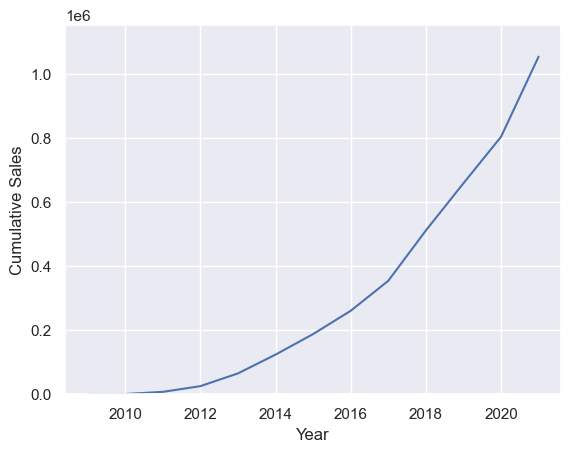

In [20]:
plt.ylim([0,max(by_year['Cumulative Sales'])+100000])
sns.lineplot(data = by_year, x = 'Year', y='Cumulative Sales', errorbar = None)

,Year,Autos,Trucks,Total_Vehicles,Delta,EV_Sales,Cumulative Sales,Total_NonEv
0,2009,21898286.0,5788504.0,27686790.0,-152695.0,84.0,84.0,27686706.0
1,2010,22040779.0,5711052.0,27751831.0,65041.0,661.0,745.0,27751086.0
2,2011,22083049.0,5561453.0,27644502.0,-107329.0,6743.0,7488.0,27637014.0
3,2012,22473717.0,5530290.0,28004007.0,359505.0,17839.0,25327.0,27978680.0
4,2013,23237523.0,5584074.0,28821597.0,817590.0,39805.0,65132.0,28756465.0
5,2014,23805920.0,5591533.0,29397453.0,575856.0,58663.0,123795.0,29273658.0
6,2015,24487807.0,5648187.0,30135994.0,738541.0,64134.0,187929.0,29948065.0
7,2016,25244537.0,5812320.0,31056857.0,920863.0,72683.0,260612.0,30796245.0
8,2017,25467663.0,5850286.0,31317949.0,261092.0,93587.0,354199.0,30963750.0
9,2018,25646228.0,5890475.0,31536703.0,218754.0,157143.0,511342.0,31025361.0


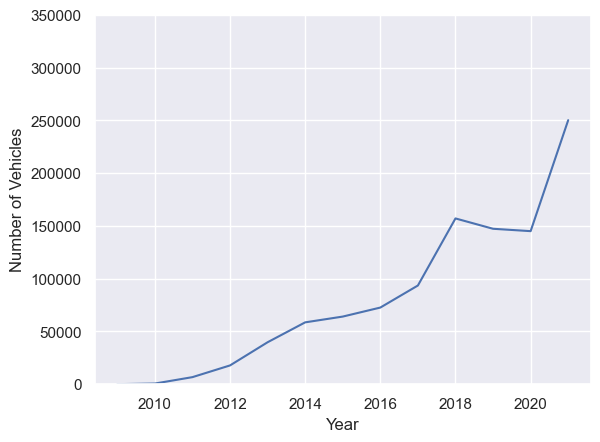

In [21]:
plt.ylim([0,max(by_year['Number of Vehicles'])+100000])
sns.lineplot(data = by_year, x = 'Year', y='Number of Vehicles', errorbar = None)
regs_v_ev

While total car ownership has fluctuated very little over the last 10 years, the sale of ZEV vehicles has increased significantly. However, as this is just a small part of overall car sales as seen, is this trend simply due to the minor uptick in car registrations since 2010 or is this statistically significant?

In [22]:

outcome, predictors = patsy.dmatrices('EV_Sales ~ Year + Total_NonEv', regs_v_ev)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               EV_Sales   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     49.92
Date:                Wed, 31 May 2023   Prob (F-statistic):           6.26e-06
Time:                        21:31:21   Log-Likelihood:                -148.34
No. Observations:                  13   AIC:                             302.7
Df Residuals:                      10   BIC:                             304.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.914e+07   9.61e+06     -5.111      

c:\users\17144\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


There does seem to be some significant correlation outside to year and ev car sales even when considering other car sales.

We can also note that for the linear model the Adj. R-squared is 0.89, however, the data looks more quadradic in the graphs, so we will see if a quadradic line of regression is more appropriate.

In [23]:
mymodel = np.poly1d(np.polyfit(regs_v_ev['EV_Sales'], regs_v_ev['Year'], 2))

print(r2_score(regs_v_ev['Year'], mymodel(regs_v_ev['EV_Sales']))) 

0.9714913203034213


There does seem to be a stronger correlation to the quadradic model, so for further analysis, a quadratic line of regression will be used.